# HW2: Sankalp Singh CIS 731 ANN


## Problem Statement

### In this assignment we will be: Selecting a data set for a forecasting or prediction problem.  Compare the performance of (a) plain backpropagation (using a few recent data points to make predictions); (b) backpropagation through time; (c) LSTM; and (d) GRU networks.

### Here, we will be using the dataset: Australian Beer Production - we will be forecasting the beer production using the quarterly data

#### Information about the dataset (AusBeer.csv):

• Time: Contains a number for all the years starting from 1

• Year: Represents the year of production

• Quarter: Represents the quarter for any given year

• Beer.Production: The amount of beer produced in Australia in a given quarter for a given year

### Import Libraries

Importing all the required libraries that will help us perform data pre-processing, visualizations, modeling and performance evaluation.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from tensorflow.keras.layers import LSTM
from keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from timeit import default_timer as timer
from keras.callbacks import History

### Reading the dataset

Here we are reading both the dataset. We can see below that our dataset contains quaterly data. So, we will be using the lag technique to forecast Beer Production

In [2]:
# Read the csv into a dataframe
df=pd.read_csv('AusBeer.csv')

In [3]:
# Printing first 5 data points in the dataset
df.head()

,Time,Year,Quarter,Beer.Production
0,1,1956,Q1,284
1,2,1956,Q2,213
2,3,1956,Q3,227
3,4,1956,Q4,308
4,5,1957,Q1,262


In [4]:
# Printing the shape
df.shape

(218, 4)

#### Plotting all the data points present in the dataset to see the overall trend for the target attribute - 'Beer.Production'

From the below trend, we can infer that beer sales increased at first and then more recently the production has dropped towards the end

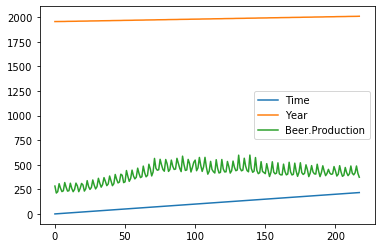

In [5]:
# Plotting all the data points to see the trend
df.plot()
plt.show()

## Data Pre-processing

Here, we have followed the CRISP-DM methodology  which consists of following steps in the mentioned order: Business & Data Understanding -> Data cleaning & Pre-processing -> Modeling -> Performance Evaluation 

We have addressed the following data issues here while performing the data pre-processing:

1) Scaling the data: We have used the MinMaxScaler to scale the data points in out dataset. This is one of the most important step in data pre-processing for Neural Networks models as it can improve the performance of our models

2) Data transfomation: We have implemented the time series forecasting using Lags. Our dataset contains quaterly data. So, we have shifted the data points for each quarter using the corresponding lags - Q1 has 1 lag data point, Q2 has 2 lag data points, Q3 has 3 data points lag and Q4 has 4 lag data points. We will be using 4 previous data points (from all 4 quarters) to predict the beer production for the 5th quarter

3) Removing null values: After transforming the data set according to our lags technique, we have removed the first four rows containing some NaN values

In [6]:
# Setting up the min max scalar
min_max_scaler = preprocessing.MinMaxScaler()

#### Transforming the dataset using a MinMaxScalar

In [7]:
# Transforming the dataset using min max scalar
df[['Time','Year','Beer.Production']] = min_max_scaler.fit_transform(df[['Time','Year','Beer.Production']])

In [8]:
# Printing first 5 rows for the scaled dataset
df.head()

,Time,Year,Quarter,Beer.Production
0,0.000000,0.000000,Q1,0.183938
1,0.004608,0.000000,Q2,0.000000
2,0.009217,0.000000,Q3,0.036269
3,0.013825,0.000000,Q4,0.246114
4,0.018433,0.018519,Q1,0.126943


#### Applying the lag technique to transform our data set. We will be feeding this transformed dataset to all of our models

In [9]:
# Applying lag technique using the shift function
for quarters in range(1,5):
    df["Quarter"+str(quarters)]=df["Beer.Production"].shift(quarters)

#### Removing the null values

In [10]:
# Removing the null values
df = df.iloc[4:]

#### Final transformed dataset that will be used for the models

In [11]:
# Printing the final transformed dataset
df.head(5)

,Time,Year,Quarter,Beer.Production,Quarter1,Quarter2,Quarter3,Quarter4
4,0.018433,0.018519,Q1,0.126943,0.246114,0.036269,0.000000,0.183938
5,0.023041,0.018519,Q2,0.038860,0.126943,0.246114,0.036269,0.000000
6,0.027650,0.018519,Q3,0.059585,0.038860,0.126943,0.246114,0.036269
7,0.032258,0.018519,Q4,0.277202,0.059585,0.038860,0.126943,0.246114
8,0.036866,0.037037,Q1,0.152850,0.277202,0.059585,0.038860,0.126943


## Modeling

- We have used all the four quarter attributes as predictors. 

- We have used the Beer Production attribue as the target variable

- We have performed a 70-30 train-validation split here

- We will be training our models on the train set and we will be evaluating our models on the validation set

- Later on we will be reshaping our train and test predictors from 2d to 3d as all the RNN models use 3d data as inputs

- We have also generated a TimeComplexity function that will help us to measure the time it takes for each model to run. This will be really helpful in comparing all the model performance later on

- We have implemented 4 different forecasting models here:
                       - Plain Backpropagation model
                       - Backpropagation through time (Recurrent Neural Network)
                       - LSTM (Long Short Term Memory)
                       - GRU (Gated Recurrent Units)

In [12]:
# Using all the quarters as the predictors
X = df.filter(['Quarter1','Quarter2','Quarter3','Quarter4'], axis=1)

In [13]:
# Using Beer production as the target variable
y = df['Beer.Production']

In [14]:
# Creating the train - validation split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [15]:
# Converting the dataframe to n-dimensional array to feed into the models
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#### Function to measure the time complexity for each model

In [16]:
# Time Complexity function
class TimeComplexity(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

## 1) Plain Backpropagation (Simple Feed Forward Neural Network) Model

- Initially we have set the seed so that model performance does not vary with each run

- Here, we have setup a simple feed forward neural network using: d-2d-1 approach that uses 4 recent data points to make the predictions

- We have used the activation function as 'relu' for the hidden layer and 'sigmoid' for the final output layer

- We have used the loss function as 'MSE' and optimizer as 'adam'

- Hyperparameters used for training:
                - epochs = 300
                - batch_size = 10



In [17]:
# Set the seed
np.random.seed(12345)
tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(8, input_dim=4, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=300, batch_size=10, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs




Epoch 1/300
15/15 [==============================] - 0s 9ms/step - loss: 0.0448 - val_loss: 0.0476
Epoch 2/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0460
Epoch 3/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0406 - val_loss: 0.0448
Epoch 4/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0439
Epoch 5/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0430
Epoch 6/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0421
Epoch 7/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.0413
Epoch 8/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0405
Epoch 9/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0397
Epoch 10/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.0388
Epoch 11/

#### Results for Plain Backpropagation Model

- Plain Backpropagation model achieved a best validation MSE of 0.0026 after 300 epochs

- Plain Backpropagation model took 11.45 seconds to complete 300 epochs

In [18]:
# Calculating the final train mse
bp_train_error = history_bp.history['loss']
print('Final Train MSE for Plain Backpropagation Model:', bp_train_error[-1] )

# Calculating the final validation mse
bp_validation_error = history_bp.history['val_loss']
print('Final Validation MSE for Plain Backpropagation Model:', bp_validation_error[-1] )

# Calculating the time complexity
bp_time_complexity = sum(time_bp)
print('Time complexity for Plain Backpropagation Model:', bp_time_complexity,'seconds')

Final Train MSE for Plain Backpropagation Model: 0.002429910935461521
Final Validation MSE for Plain Backpropagation Model: 0.0026725297793745995
Time complexity for Plain Backpropagation Model: 11.456601586999284 seconds


#### Plotting MSE vs Number of weight updates for Plain Backpropagation Model

- From the below graph we can infer that after almost 25 epochs the train and validation mse for this model starts to converge on a single line

- Finally, the validation error is just a bit more than the train error after 300 epochs

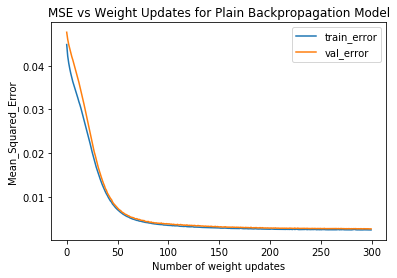

In [19]:
# Plotting MSE vs Weight updates
plt.plot(bp_train_error)
plt.plot(bp_validation_error)
plt.title('MSE vs Weight Updates for Plain Backpropagation Model')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['train_error', 'val_error'], loc='upper right')
plt.show()

#### Reshaping the X_train and X_test arrays from 2-dim to 3-dim as the RNN, LSTM and GRU models require the input shape for the training data as 3-dim. The dimensions will be: (observations, TimeSteps, features)

In [20]:
# Reshaping X_train
X_train = np.arange(596).reshape(149,1,4)

In [21]:
# Reshaping X_test
X_test = np.arange(260).reshape(65,1,4)

## 2) Backpropagation through Time (Recurrent Neural Network) Model

- Initially we have set the seed so that model performance does not vary with each run

- Here, we have setup a RNN model that uses backpropagation through time

- We have used the activation function as 'relu' for the SimpleRNN layer. We have used a single RNN unit and input shape is [TimeSteps, features] i.e. [1,4]

- We have used the loss function as 'MSE' and optimizer as 'adam'

- Hyperparameters used for training:
                - epochs = 300
                - batch_size = 10



In [22]:
# Set the seed
np.random.seed(12345)
tf.random.set_seed(12345)

# Invoking time complexity function
tc_bptt = TimeComplexity()

# Invoking history function
history=History()

# Building Simple RNN model using backpropagation through time
model_bptt = Sequential()
model_bptt.add(SimpleRNN(units=1, input_shape=[1,4], activation='relu'))
model_bptt.add(Dense(1))

# Compiling the model
model_bptt.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model
history_bptt = model_bptt.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=300, batch_size=10, callbacks=[tc_bptt,history])

# Calculating the time taken for each epoch
time_bptt=tc_bptt.logs

Epoch 1/300
15/15 [==============================] - 0s 13ms/step - loss: 0.3281 - val_loss: 0.3015
Epoch 2/300
15/15 [==============================] - 0s 3ms/step - loss: 0.3123 - val_loss: 0.2869
Epoch 3/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2975 - val_loss: 0.2728
Epoch 4/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2831 - val_loss: 0.2593
Epoch 5/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2693 - val_loss: 0.2466
Epoch 6/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2561 - val_loss: 0.2344
Epoch 7/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2437 - val_loss: 0.2227
Epoch 8/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2315 - val_loss: 0.2118
Epoch 9/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2203 - val_loss: 0.2013
Epoch 10/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2093 - val_loss: 0.1913
Epoch 11

#### Results for Backpropagation through time (RNN) Model

- Backpropagation through time model achieved a best validation MSE of 0.0507 after 300 epochs

- Backpropagation through time model took 13.54 seconds to complete 300 epochs

In [23]:
# Calculating the final train mse
bptt_train_error = history_bptt.history['loss']
print('Final Train MSE for Backpropagation through time Model:', bptt_train_error[-1] )

# Calculating the final validation mse
bptt_validation_error = history_bptt.history['val_loss']
print('Final Validation MSE for Plain Backpropagation Model:', bptt_validation_error[-1] )

# Calculating the time complexity
bptt_time_complexity = sum(time_bptt)
print('Time complexity for Plain Backpropagation Model:', bptt_time_complexity,'seconds')

Final Train MSE for Backpropagation through time Model: 0.045256324112415314
Final Validation MSE for Plain Backpropagation Model: 0.050718724727630615
Time complexity for Plain Backpropagation Model: 13.548878374998878 seconds


#### Plotting MSE vs Number of weight updates for Backpropagation through time (RNN) Model

- From the below graph we can infer that initially the train and validation errors are almost the same. Then after almost 50 epochs the validation error starts to increase a bit as compared to the train error

- After that point, there is a constant difference in the validation error and train error till 300 epochs

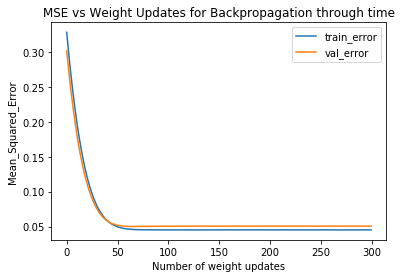

In [24]:
# Plotting MSE vs Weight updates
plt.plot(bptt_train_error)
plt.plot(bptt_validation_error)
plt.title('MSE vs Weight Updates for Backpropagation through time')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['train_error', 'val_error'], loc='upper right')
plt.show()

## 3) Long Short Term Memory (LSTM) Model

- Initially we have set the seed so that model performance does not vary with each run

- Here, we have setup a LSTM model

- We have used the activation function as 'relu' for the LSTM layer. We have used a single LSTM unit and input shape is [TimeSteps, features] i.e. [1,4]

- We have used the loss function as 'MSE' and optimizer as 'adam'

- Hyperparameters used for training:
                - epochs = 300
                - batch_size = 10



In [25]:
# Set the seed
np.random.seed(12345)
tf.random.set_seed(12345)

# Invoking time complexity function
tc_lstm = TimeComplexity()

# Invoking history function
history=History()

# Building the LSTM model 
model_lstm = Sequential()
model_lstm.add(LSTM(units=1, input_shape=[1,4], activation='relu'))
model_lstm.add(Dense(1))

# Compiling the model
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=300, batch_size=10, callbacks=[tc_lstm,history])

# Calculating the time taken for each epoch
time_lstm=tc_lstm.logs

Epoch 1/300
15/15 [==============================] - 0s 15ms/step - loss: 0.3281 - val_loss: 0.3015
Epoch 2/300
15/15 [==============================] - 0s 3ms/step - loss: 0.3123 - val_loss: 0.2869
Epoch 3/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2975 - val_loss: 0.2728
Epoch 4/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2831 - val_loss: 0.2593
Epoch 5/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2693 - val_loss: 0.2466
Epoch 6/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2561 - val_loss: 0.2344
Epoch 7/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2437 - val_loss: 0.2227
Epoch 8/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2315 - val_loss: 0.2118
Epoch 9/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2203 - val_loss: 0.2013
Epoch 10/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2093 - val_loss: 0.1913
Epoch 11

#### Results for LSTM Model

- LSTM model achieved a best validation MSE of 0.0507 after 300 epochs

- LSTM model took 15.25 seconds to complete 300 epochs

In [26]:
# Calculating the final train mse
lstm_train_error = history_lstm.history['loss']
print('Final Train MSE for Backpropagation through time Model:', lstm_train_error[-1] )

# Calculating the final validation mse
lstm_validation_error = history_lstm.history['val_loss']
print('Final Validation MSE for Plain Backpropagation Model:', lstm_validation_error[-1] )

# Calculating the time complexity
lstm_time_complexity = sum(time_lstm)
print('Time complexity for Plain Backpropagation Model:', lstm_time_complexity,'seconds')

Final Train MSE for Backpropagation through time Model: 0.045256324112415314
Final Validation MSE for Plain Backpropagation Model: 0.050718724727630615
Time complexity for Plain Backpropagation Model: 15.258440700000278 seconds


#### Plotting MSE vs Number of weight updates for LSTM Model

- From the below graph we can infer that initially the train and validation errors are almost the same. Then after almost 50 epochs the validation error starts to increase a bit as compared to the train error

- After that point, there is a constant difference in the validation error and train error till 300 epochs

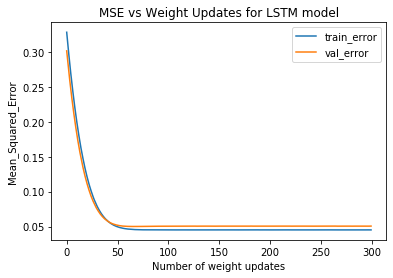

In [27]:
# Plotting MSE vs Weight updates
plt.plot(lstm_train_error)
plt.plot(lstm_validation_error)
plt.title('MSE vs Weight Updates for LSTM model')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['train_error', 'val_error'], loc='upper right')
plt.show()

## 4) Gated Recurrent Units (GRU) Model

- Initially we have set the seed so that model performance does not vary with each run

- Here, we have setup a GRU model

- We have used the activation function as 'relu' for the GRU layer. We have used a single GRU unit and input shape is [TimeSteps, features] i.e. [1,4]

- We have used the loss function as 'MSE' and optimizer as 'adam'

- Hyperparameters used for training:
                - epochs = 300
                - batch_size = 10



In [28]:
# Set the seed
np.random.seed(12345)
tf.random.set_seed(12345)

# Invoking time complexity function
tc_gru = TimeComplexity()

# Invoking history function
history=History()

# Building the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=1, input_shape=[1,4], activation='relu'))
model_gru.add(Dense(1))

# Compiling the model
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=300, batch_size=10, callbacks=[tc_gru,history])

# Calculating the time taken for each epoch
time_gru=tc_gru.logs

Epoch 1/300
15/15 [==============================] - 0s 15ms/step - loss: 0.3240 - val_loss: 0.2978
Epoch 2/300
15/15 [==============================] - 0s 3ms/step - loss: 0.3078 - val_loss: 0.2833
Epoch 3/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2927 - val_loss: 0.2693
Epoch 4/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2781 - val_loss: 0.2559
Epoch 5/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2639 - val_loss: 0.2433
Epoch 6/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2505 - val_loss: 0.2315
Epoch 7/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2379 - val_loss: 0.2204
Epoch 8/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2255 - val_loss: 0.2101
Epoch 9/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2142 - val_loss: 0.2004
Epoch 10/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2035 - val_loss: 0.1912
Epoch 11

#### Results for GRU Model

- GRU model achieved a best validation MSE of 0.0553 after 300 epochs

- GRU model took 16 seconds to complete 300 epochs

In [29]:
# Calculating the final train mse
gru_train_error = history_gru.history['loss']
print('Final Train MSE for Backpropagation through time Model:', gru_train_error[-1] )

# Calculating the final validation mse
gru_validation_error = history_gru.history['val_loss']
print('Final Validation MSE for Plain Backpropagation Model:', gru_validation_error[-1] )

# Calculating the time complexity
gru_time_complexity = sum(time_gru)
print('Time complexity for Plain Backpropagation Model:', gru_time_complexity,'seconds')

Final Train MSE for Backpropagation through time Model: 0.04426112771034241
Final Validation MSE for Plain Backpropagation Model: 0.055314190685749054
Time complexity for Plain Backpropagation Model: 16.009557031000384 seconds


#### Plotting MSE vs Number of weight updates for GRU Model

- From the below graph we can infer that initially the train and validation errors are almost the same. Then after almost 40 epochs the validation error starts to increase a bit as compared to the train error

- After that point, there is a constant difference in the validation error and train error till 300 epochs

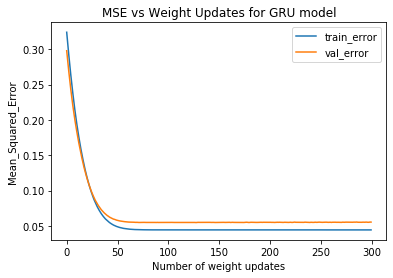

In [30]:
# Plotting MSE vs Weight updates
plt.plot(gru_train_error)
plt.plot(gru_validation_error)
plt.title('MSE vs Weight Updates for GRU model')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['train_error', 'val_error'], loc='upper right')
plt.show()

## Conclusion: Comparing Model's Performance

-  Here, we have used two techniques in order to compare the performance of our 4 models

1) We have plotted a single graph for validation MSE of all the models vs the Number of weight updates

2) We have plotted a scatter plot to compare the time complexity for all the 4 models

-  Our first plot shows us that Plain Backpropagation model has the lowest validation MSE. Backpropagation through time model and LSTM model, both achieved the exact same performance. GRU model has the highest validation error. This shows us that accordind to the validation mse evaluation metric, we can say that Plain Backpropagation model has performed the best out of all models for forecasting the beer production in Australia


- Our second plot shows that GRU model has the highest time complexity. This is followed by LSTM model which is inturn followed by BPTT model. Here as well, Plain Backpropagation model takes the lowest time to complete and proves to be fastest model for forecasting beer production in Australia


- So, overall we can conclude that for our Beer Production dataset, Plain Backpropagation model has the lowest validation error and has the lowest time complexity as well. So, we can say infer that for our beer production forecasting data, Plain Backpropagation model is by far the best compared to all the other models

#### Plotting validation MSE for all the models vs the Number of weight updates

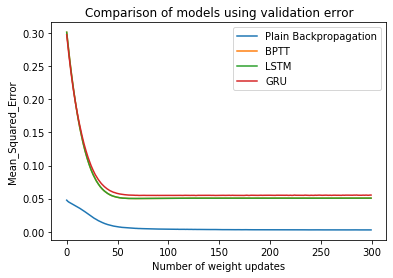

In [31]:
# Plotting validation MSE of all the models vs the Number of weight updates
plt.plot(bp_validation_error)
plt.plot(bptt_validation_error)
plt.plot(lstm_validation_error)
plt.plot(gru_validation_error)
plt.title('Comparison of models using validation error')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['Plain Backpropagation', 'BPTT', 'LSTM', 'GRU'], loc='upper right')
plt.show()

In [32]:
# Storing the final validation for all models in a list
lowest_mse_obtained = [bp_validation_error[-1],bptt_validation_error[-1],lstm_validation_error[-1],gru_validation_error[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity,bptt_time_complexity,lstm_time_complexity,gru_time_complexity]

# Creating a list with all the model names
models = ['Plain Back Propagation', 'BPTT', 'LSTM', 'GRU']

#### Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation errors

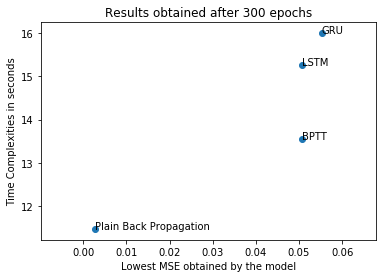

In [33]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_mse_obtained, time_complexities)

plt.title('Results obtained after 300 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest MSE obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_mse_obtained[x], time_complexities[x]))    

#### Final comparison of all the models

Overall, we can conclude that for our Beer Production dataset, Plain Backpropagation model has the lowest validation error and has the lowest time complexity as well. So, we can infer that for our beer production forecasting data, Plain Backpropagation model is by far the best compared to all the other models

In [34]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["Plain Backpropagation","BPTT","LSTM", "GRU"], "Lowest validation MSE Obtained":lowest_mse_obtained,
                            "Time Complexity in seconds":time_complexities,
                                               })

In [35]:
# Printing model summary
model_summary

,Model,Lowest validation MSE Obtained,Time Complexity in seconds
0,Plain Backpropagation,0.002673,11.456602
1,BPTT,0.050719,13.548878
2,LSTM,0.050719,15.258441
3,GRU,0.055314,16.009557
